# Price per square meter as a function of apartment size in the Finnish real-estate market

Based on browsing apartment ads it seems that small apartments are more expensive per square meter than larger apartments. I wanted to find out if this is true, and quantify the results.

The data is scraped from https://asuntojen.hintatiedot.fi/haku/.

## Part 1: Gathering data

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
#TODO

# 1. Avoid '\xa0 in parsing'
# 2. Random forest not great for lots of OH-encoded values. Try LightGBM and/or XGBOOST
# 3. Cat boost for categorical variables?

In [3]:
def parse_website(postal_code):
    '''
    Connects to asuntojen.hintatiedot.fi and pulls data on sold apartments from the last 12 months.
    
    
    Parameters:
    postal_code (str): Postal area code to get data for
    
    Returns:
    Nested list with apartment data
    
    '''
    URL = 'https://asuntojen.hintatiedot.fi/haku/?c=&cr=1&ps=' + postal_code + '&nc=0&amin=&amax=&renderType=renderTypeTable&search=1'
    
    page = requests.get(URL)

    soup = BeautifulSoup(page.content, 'html.parser')

    main_table = soup.find(id='mainTable')

    apartments = main_table.find_all('tr', class_="")
    
    
    local_area_apartments = []
    for a in apartments[4:-2]: # First 4 and last 2 'td' tags are not apartment information
        elements = a.find_all('td')

        parsed_apartment = [element.text.replace("\xa0", "") for element in elements]
        
        if len(parsed_apartment) < 2:
            continue
        parsed_apartment[3] = parsed_apartment[3].replace(",", ".") #Change to international decimal delimiter
        #parsed_apartment[9] = parsed_apartment[9].replace("\xa0", "") #Change to international decimal delimiter
        parsed_apartment[10] = parsed_apartment[10].split("\t")[0] #Weird formatting in source website
        parsed_apartment.append(postal_code)
        local_area_apartments.append(parsed_apartment)
        
    return local_area_apartments
    

In [4]:
parsed_apartments = []
postal_codes_helsinki = ['00'+str(10*i) for i in range(10,100)] #All Helsinki postal codes
postal_codes_espoo = ['0'+str(10*i) for i in range(210,298)]
postal_codes_vantaa = ['0'+str(10*i) for i in range(120,177)]

postal_codes = postal_codes_helsinki + postal_codes_espoo + postal_codes_vantaa

count = 0
for postal_code in postal_codes:
    apartments = parse_website(postal_code)
    for apartment in apartments:
        parsed_apartments.append(apartment)
    if count%10 == 0:
        print(f"Parsed {count}/{len(postal_codes)} postal codes")
    count += 1
print("Parsed all postal codes")

Parsed 0/235 postal codes
Parsed 10/235 postal codes
Parsed 20/235 postal codes
Parsed 30/235 postal codes
Parsed 40/235 postal codes
Parsed 50/235 postal codes
Parsed 60/235 postal codes
Parsed 70/235 postal codes
Parsed 80/235 postal codes
Parsed 90/235 postal codes
Parsed 100/235 postal codes
Parsed 110/235 postal codes
Parsed 120/235 postal codes
Parsed 130/235 postal codes
Parsed 140/235 postal codes
Parsed 150/235 postal codes
Parsed 160/235 postal codes
Parsed 170/235 postal codes
Parsed 180/235 postal codes
Parsed 190/235 postal codes
Parsed 200/235 postal codes
Parsed 210/235 postal codes
Parsed 220/235 postal codes
Parsed 230/235 postal codes
Parsed all postal codes


In [5]:
columns = ['neighborhood', 'apartment_type', 'house_type', 'sqm', 'price', 'price_per_sqm', 'year_built', 'floor', 'elevator', 'condition', 'plot_ownership', 'energy_class', 'postal_code']
df = pd.DataFrame(parsed_apartments,columns=columns)

to_numeric_columns = ['sqm', 'price', 'price_per_sqm', 'year_built']
for column in to_numeric_columns:
    df[column] = pd.to_numeric(df[column])

#Outputting data to .csv file in order to save data and avoid the need to pull data again
df.to_csv("apartment_prices.csv")

In [6]:
df.head()

,neighborhood,apartment_type,house_type,sqm,price,price_per_sqm,year_built,floor,elevator,condition,plot_ownership,energy_class,postal_code
0,Etu-töölö,"1h, avok, kph, kht",kt,24.0,217000,9042,1929,6/7,on,hyvä,oma,E2018,00100
1,Etu-töölö,"1h, kk",kt,28.0,260000,9286,1927,1/6,on,tyyd.,oma,F2013,00100
2,Etu-töölö,1h+k,kt,41.0,320000,7805,1911,2/5,ei,hyvä,oma,E2018,00100
3,Töölö,"1h,ikk.kk,kh",kt,23.0,226000,9826,1934,1/3,ei,tyyd.,oma,D2013,00100
4,Keskusta,"1h,k",kt,47.9,500000,10438,1905,3/3,ei,tyyd.,oma,G,00100


In [7]:
df.describe()

,sqm,price,price_per_sqm,year_built
count,4788.000000,4.788000e+03,4788.000000,4788.000000
mean,66.192607,2.600758e+05,4347.590434,1981.800543
std,33.969017,1.311311e+05,2072.094916,27.545228
min,6.000000,1.466000e+03,74.000000,1850.000000
25%,45.000000,1.720000e+05,2897.000000,1964.000000
50%,59.000000,2.350000e+05,3860.000000,1982.000000
75%,79.500000,3.175000e+05,5370.250000,2006.000000
max,323.100000,1.678000e+06,33228.000000,2021.000000


## Part 2: Data visualisation and preprocessing

In [8]:
# We will use house type, sqm, price, year_built, floor, elevator, condition, plot_ownership and postal_code
# To predict the price_per_sqm
cols = ['price_per_sqm','house_type', 'sqm', 'price', 'year_built', 'floor', 'elevator', 'condition', 'plot_ownership', 'postal_code']
df_ml = df[cols].copy(deep=True)
df_ml.replace('', np.nan, inplace=True)

#Find columns with missing values
columns_with_missing_values = [col for col in df_ml.columns if df_ml[col].isna().any()]

for col in columns_with_missing_values:
    print(f"Count of values in column {col} = {df_ml[df_ml[col].isna()].index.size}")

#As the count of rows containing missing values is somewhat low, the corresponding rows are dropped
df_ml.dropna(axis=0, inplace=True)

Count of values in column floor = 64
Count of values in column condition = 50
Count of values in column plot_ownership = 59


Text(0.5, 0, 'Year built (kt only)')

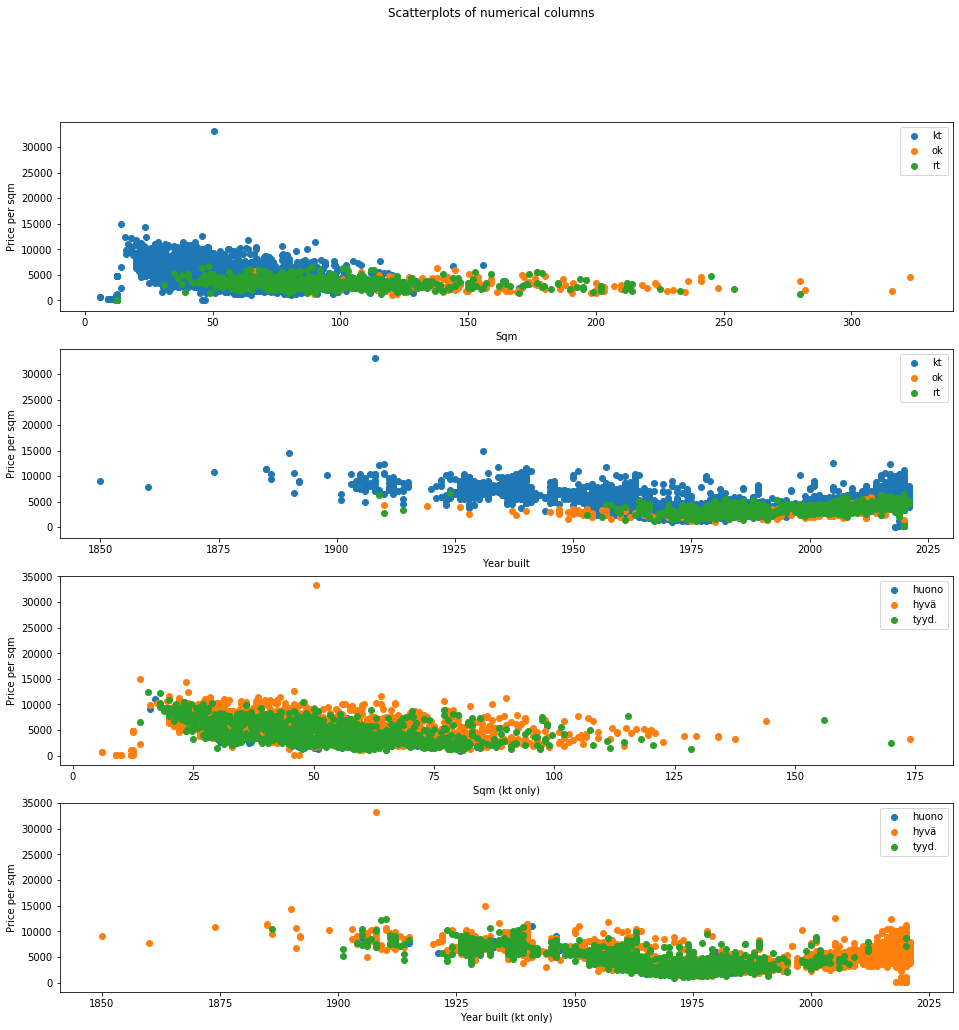

In [9]:
groups_house_types = df_ml.groupby('house_type') # For plotting different colours per house type
groups_condition_in_kt = df_ml[df_ml['house_type']=='kt'].groupby('condition') # Colours depending on condition
fig, axs = plt.subplots(4, figsize=(16, 16))
fig.suptitle('Scatterplots of numerical columns')

for name, group in groups_house_types:
    axs[0].scatter(group['sqm'], group['price_per_sqm'], label=name)
    axs[1].scatter(group['year_built'], group['price_per_sqm'], label=name)

for name, group in groups_condition_in_kt:
    axs[2].scatter(group['sqm'], group['price_per_sqm'], label=name)
    axs[3].scatter(group['year_built'], group['price_per_sqm'], label=name)
    
axs[0].legend()
axs[1].legend()
axs[2].legend()
axs[3].legend()

for ax in axs:
    ax.set_ylabel('Price per sqm')
axs[0].set_xlabel('Sqm')
axs[1].set_xlabel('Year built')
axs[2].set_xlabel('Sqm (kt only)')
axs[3].set_xlabel('Year built (kt only)')

The first subplot does show higher prices per square meter for smaller apartments. It also suggests that apartment buildings (kt) generally have smaller apartments than separate houses (ok) and row houses (rt).

It is also obvious that there is an outlier with over 30k€ per sqm, as well as many new good condition apartments that are very cheap. These are removed below

In [10]:
outliers = df_ml[(df_ml['price_per_sqm'] > 30000) | (df_ml['price_per_sqm'] < 400)]
print(f"Count of outliers {outliers.index.size}")
outliers

Count of outliers 21


,price_per_sqm,house_type,sqm,price,year_built,floor,elevator,condition,plot_ownership,postal_code
140,33228,kt,50.5,1678000,1908,5/5,ei,hyvä,oma,00140
918,120,rt,12.5,1500,2020,1/2,ei,hyvä,vuokra,00410
926,120,rt,12.5,1500,2020,1/2,ei,hyvä,vuokra,00410
928,120,rt,12.5,1500,2020,1/2,ei,hyvä,vuokra,00410
929,120,rt,12.5,1500,2020,1/2,ei,hyvä,vuokra,00410
931,120,rt,12.5,1500,2020,1/2,ei,hyvä,vuokra,00410
932,120,rt,12.5,1500,2020,1/2,ei,hyvä,vuokra,00410
3248,150,kt,10.0,1502,2020,1/1,on,hyvä,vuokra,02430
3249,123,kt,12.0,1480,2020,1/1,on,hyvä,vuokra,02430
3250,123,kt,12.0,1480,2020,1/1,on,hyvä,vuokra,02430


In [11]:
# Drop the outlier data
df_ml.drop(outliers.index, axis=0, inplace=True)

In [12]:
# We will use house type, sqm, price, year_built, floor, elevator, condition, plot_ownership and postal_code
# To predict the price_per_sqm

def parse_floor(row):
    '''
    Converts the string describing current and total floors to usable features.
    '''
    floors = row['floor'].split('/')
    try:
        row['floors'] = float(floors[1])
        row['current_floor'] = float(floors[0])
        row['floor_ratio'] = float(floors[0])/float(floors[1])
    except:
        pass
    return row

df_ml['floors'] = pd.Series()
df_ml['current_floor'] = pd.Series()
df_ml['floor_ratio'] = pd.Series()

df_ml = df_ml.apply(parse_floor, axis='columns')

features = df_ml.drop(['price_per_sqm', 'floor', 'price'], axis=1)
labels = df_ml['price_per_sqm']

features_train, features_test, labels_train, labels_test = train_test_split(features, labels, random_state=0) 

In [13]:
features_train

,house_type,sqm,year_built,elevator,condition,plot_ownership,postal_code,floors,current_floor,floor_ratio
121,kt,57.5,1915,on,hyvä,oma,00140,7.0,1.0,0.142857
265,kt,34.5,1971,on,hyvä,oma,00180,5.0,4.0,0.800000
608,kt,27.0,1961,ei,hyvä,oma,00320,3.0,1.0,0.333333
1815,kt,53.5,1982,ei,tyyd.,oma,00730,3.0,2.0,0.666667
921,rt,72.0,2020,ei,hyvä,vuokra,00410,2.0,1.0,0.500000
...,...,...,...,...,...,...,...,...,...,...
1061,kt,35.0,1930,on,hyvä,oma,00500,7.0,3.0,0.428571
3382,kt,121.0,2000,on,hyvä,oma,02600,5.0,5.0,1.000000
1695,rt,72.0,2019,ei,hyvä,oma,00700,2.0,1.0,0.500000
2688,kt,102.0,2006,on,hyvä,oma,00990,7.0,3.0,0.428571


In [14]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor

numerical_cols = ['sqm', 'year_built', 'floors', 'current_floor']
ordinal_cols = ['elevator', 'condition', 'plot_ownership']
categorical_cols = ['house_type', 'postal_code']

ordinal_transformer = Pipeline(steps=[('ordinal', OrdinalEncoder())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
minmax_scaler = Pipeline(steps=[('minmax', MinMaxScaler(feature_range=(0,1)))])

preprocessor = ColumnTransformer(
    transformers = [
        ('ord', ordinal_transformer, ordinal_cols),
        ('cat', categorical_transformer, categorical_cols),
        ('minmax', minmax_scaler, numerical_cols)
    ])


random_forest = RandomForestRegressor(n_estimators=100)
random_forest_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                ('model', random_forest)])
random_forest_pipeline.fit(features_train, labels_train)

score = cross_val_score(random_forest_pipeline, features_train, labels_train, cv=5, scoring='r2')
print(f"R2 scores in cross validation: {score}")

R2 scores in cross validation: [0.84623642 0.83890728 0.85685846 0.86284922 0.85670717]


## Part n: Below testing, unfinished parts

In [17]:
parameters = {'model__n_estimators': [40, 60, 80, 100, 120, 140, 160, 180]}
CV = GridSearchCV(random_forest_pipeline, parameters, scoring = 'r2', cv=5)
CV.fit(features_train, labels_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('ord',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('ordinal',
                                                                                          OrdinalEncoder(categories='auto',
                                                                                                         dtype=<class 'numpy.float64'>))

In [18]:
CV.best_params_

{'model__n_estimators': 180}

In [20]:
# Feature importances
print(sorted(zip(map(lambda x: round(x, 4), random_forest.feature_importances_), features_train.columns), reverse=True))

[(0.0214, 'floor_ratio'), (0.0205, 'year_built'), (0.0195, 'elevator'), (0.0095, 'house_type'), (0.0076, 'sqm'), (0.0051, 'floors'), (0.0028, 'condition'), (0.0021, 'postal_code'), (0.0015, 'plot_ownership'), (0.0013, 'current_floor')]


In [21]:
# Example apartments for fun

known_apts = {'house_type' : ['kt', 'rt', 'rt'],
        'sqm': [42, 75, 115],
        'year_built': [1927, 2019, 1991],
        'elevator': ['on', 'ei', 'ei'],
        'condition': ['hyvä', 'hyvä', 'tyyd.'],
        'plot_ownership':['oma', 'vuokra', 'oma'],
        'postal_code':['00100', '02740', '00740'],
        'floors':[7, 2, 2],
        'current_floor':[3, 2, 2],
        'floor_ratio':[3/7, 1, 1]}

known_apartments = pd.DataFrame.from_dict(known_apts)

random_forest_pipeline.predict(known_apartments)

array([8129.22      , 3918.88621265, 2724.51      ])

## Testing LightGBM
Note: Can work also with categorical variables

In [23]:
from lightgbm import LGBMRegressor

lgbm = LGBMRegressor()


lgbm_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                ('model', lgbm)])

lgbm_pipeline.fit(features_train, labels_train)

lgbm_score = cross_val_score(lgbm_pipeline, features_train, labels_train, cv=5, scoring='r2')

lgbm_score

array([0.84647695, 0.84984548, 0.84003419, 0.85462859, 0.83060262])